# The Task

Building a machine learning model to **predict car price** using all of the provided features.

# The Data

a modified version of the car price [dataset](https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv) from [Kaggle](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction).

In [1]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


In [2]:
## Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import joblib

## setting random state for reproducibility
SEED = 42
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [3]:
## Load in the student performance - portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv"
df = pd.read_csv(url)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## Preprocessing the data

In [4]:
# train test split
## Make x and y variables
y = df['price']
X = df.drop(columns=['price'])
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
90,1,diesel,std,two,sedan,fwd,front,94.5,165.3,63.8,54.5,2017,ohc,4,103,idi,2.99,3.47,21.9,55,4800,45,50
173,-1,gas,std,four,sedan,fwd,front,102.4,175.6,66.5,54.9,2326,ohc,4,122,mpfi,3.31,3.54,8.7,92,4200,29,34
93,1,gas,std,four,wagon,fwd,front,94.5,170.2,63.8,53.5,2024,ohc,4,97,2bbl,3.15,3.29,9.4,69,5200,31,37
5,2,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,5,136,mpfi,3.19,3.40,8.5,110,5500,19,25
167,2,gas,std,two,hardtop,rwd,front,98.4,176.2,65.6,52.0,2540,ohc,4,146,mpfi,3.62,3.50,9.3,116,4800,24,30


In [5]:
# Preprocessing
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')

## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x128ba95b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x128ba95e0>)],
                  verbose_feature_names_out=False)

In [6]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginelocation_rear', 'enginetype_dohc', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_1bbl',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi'],
      dtype=object)

In [7]:
# Remaking Our X_train and X_test as DataFrames with the New Feature Names
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
90,1.0,94.5,165.3,63.8,54.5,2017.0,4.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
173,-1.0,102.4,175.6,66.5,54.9,2326.0,4.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
93,1.0,94.5,170.2,63.8,53.5,2024.0,4.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2.0,99.8,177.3,66.3,53.1,2507.0,5.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
167,2.0,98.4,176.2,65.6,52.0,2540.0,4.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
15,0.0,103.5,189.0,66.9,55.7,3230.0,6.0,209.0,3.62,3.39,8.00,182.0,5400.0,16.0,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,99.5,178.2,67.9,52.0,3053.0,5.0,131.0,3.13,3.40,7.00,160.0,5500.0,16.0,22.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100,0.0,97.2,173.4,65.2,54.7,2302.0,4.0,120.0,3.33,3.47,8.50,97.0,5200.0,27.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
132,3.0,99.1,186.6,66.5,56.1,2658.0,4.0,121.0,3.54,3.07,9.31,110.0,5250.0,21.0,28.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68,-1.0,110.0,190.9,70.3,58.7,3750.0,5.0,183.0,3.58,3.64,21.50,123.0,4350.0,22.0,25.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
## confirm the first 5 rows index in y_test matches X_test_df
y_test.head()

15     30760.000
9      17859.167
100     9549.000
132    11850.000
68     28248.000
Name: price, dtype: float64

# Fit and evaluate a Tree Based Model 

In [10]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [11]:
rf_reg = RandomForestRegressor(random_state=SEED)
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.99	RMSE= 928.62
Test Data:	R^2= 0.94	RMSE= 1975.42


# Extract and Plot the Feature Importances calculated by your model.


In [12]:
rf_reg.feature_importances_

array([9.33922720e-04, 4.39355838e-03, 1.29590517e-02, 1.22507814e-02,
       2.49173783e-03, 1.62318106e-01, 7.10171183e-03, 6.24941469e-01,
       4.61912905e-03, 4.51077745e-03, 3.24369826e-03, 3.28182296e-02,
       6.57005413e-03, 8.14137336e-03, 1.01308951e-01, 3.47422739e-05,
       3.57321594e-05, 8.65189930e-04, 6.84471501e-04, 2.06111112e-04,
       1.92301685e-04, 1.43416366e-03, 9.96501740e-04, 6.42642861e-04,
       7.74886119e-04, 4.33394575e-04, 2.51989027e-04, 3.24726391e-04,
       1.18657723e-03, 1.45104975e-05, 1.94216389e-05, 1.35683043e-04,
       8.51480090e-05, 9.57278516e-05, 1.47149264e-03, 3.93764034e-05,
       9.71587123e-05, 5.35541674e-05, 1.18718414e-05, 3.43096102e-04,
       4.52827407e-05, 2.25161089e-04, 6.91043715e-04, 4.48063740e-06,
       1.00927813e-06])

In [13]:
## Checking the number of feature importances matches the # of columns
print(len(rf_reg.feature_importances_))
print(len(X_train_df.columns))
len(rf_reg.feature_importances_) == len(X_train_df.columns)

45
45


True

## Saving the importances as a Pandas Series


In [14]:
## Saving the feature importances
importances = pd.Series(rf_reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances.head()

symboling    0.000934
wheelbase    0.004394
carlength    0.012959
carwidth     0.012251
carheight    0.002492
Name: Feature Importance, dtype: float64

As you can see, we now have a value for each feature used by our model.

- the importances are all small values (below 1).
- the importances sum up to 1 overall.

In [15]:
importances.sum()

1.0000000000000002

## Plotting

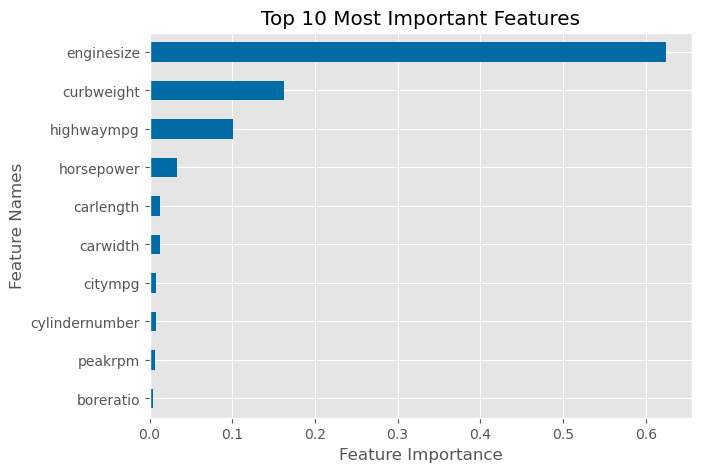

In [16]:
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
## plotting top 10 importances and adding more spice
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Feature Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

## What were your 5 most important features?

My random forest model suggests enginesize, curbweight, highwaympg, horsepower and carlength are the five most important features in feature importance.

## What does it mean that they were "important"?

An important feature is the one the often being used extensively and repeatedly by the model during the training process.

In [17]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

##  Permutation importances

In [18]:
## Permutation importance takes a fit model and the test data.
r = permutation_importance(rf_reg, X_train_df, y_train,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [19]:
##  pull out the importances_mean and make it a Pandas Series 
## so it is easy to work with.
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances.head()

enginesize    0.785768
curbweight    0.137351
highwaympg    0.051398
horsepower    0.019866
carlength     0.009468
Name: permutation importance, dtype: float64

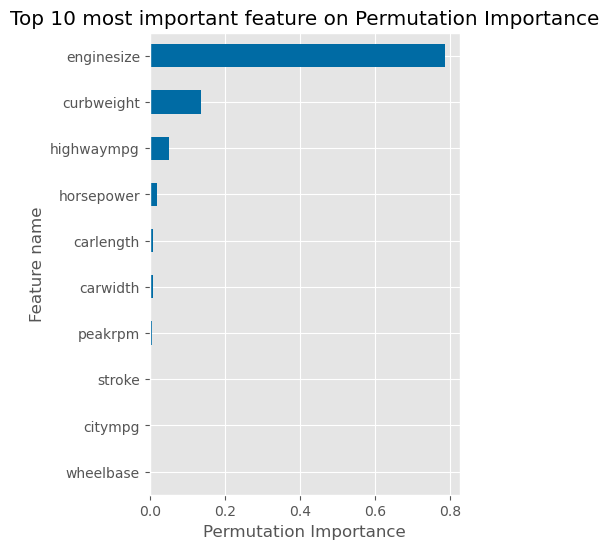

In [21]:
ax = permutation_importances.sort_values().tail(10).plot(kind='barh', figsize=(4,6))
ax.set(xlabel='Permutation Importance', ylabel='Feature name', title='Top 10 most important feature on Permutation Importance');

## What were your 5 most important features?

My random forest model suggests enginesize, curbweight, highwaympg, horsepower and carlength are the five most important features in Permutation Importance.

## Are they the same features that your model has as the top 5 important?

Yes, on my random forest model, the top five features are the same in both feature and permutation importance.